Epoch 1/50
6782/6782 [==============================] - 15s 2ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 2/50
6782/6782 [==============================] - 13s 2ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 3/50
6782/6782 [==============================] - 13s 2ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 4/50
6782/6782 [==============================] - 13s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 5/50
6782/6782 [==============================] - 14s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/50
6782/6782 [==============================] - 15s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/50
6782/6782 [==============================] - 13s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/50
6782/6782 [==============================] - 14s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/50
6782/6782 [==============================] - 14s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 10/50
6782/6782 [==============================] - 14s 2ms/step - l

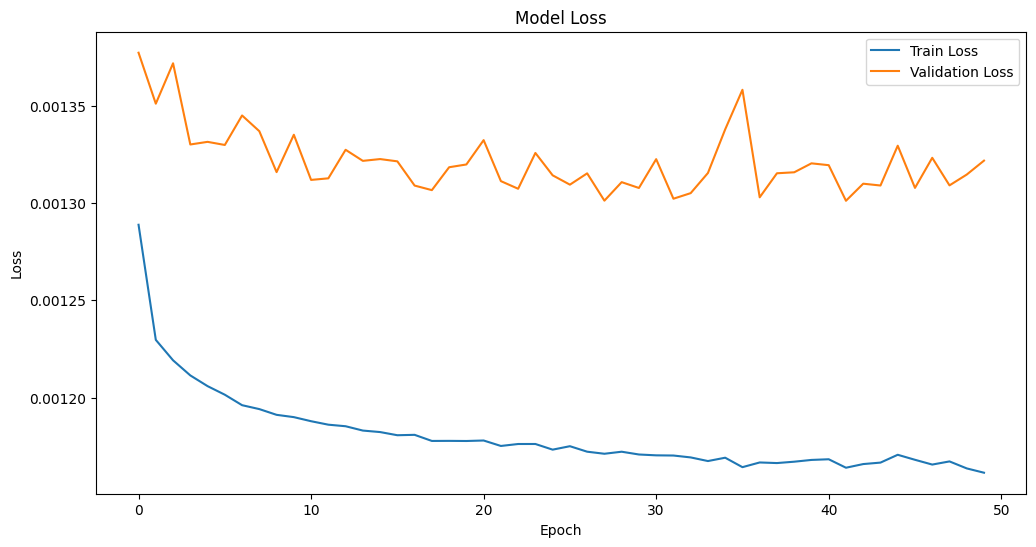

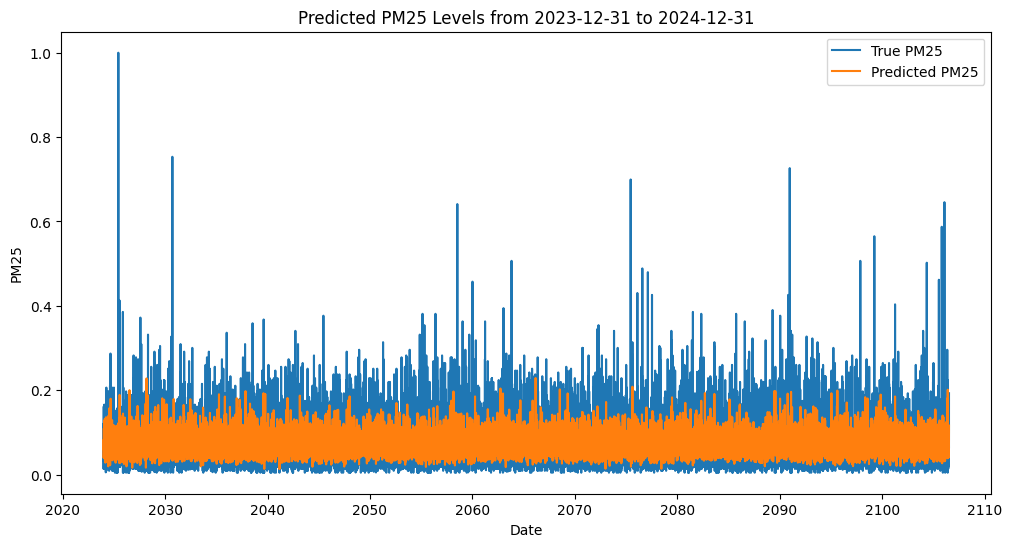

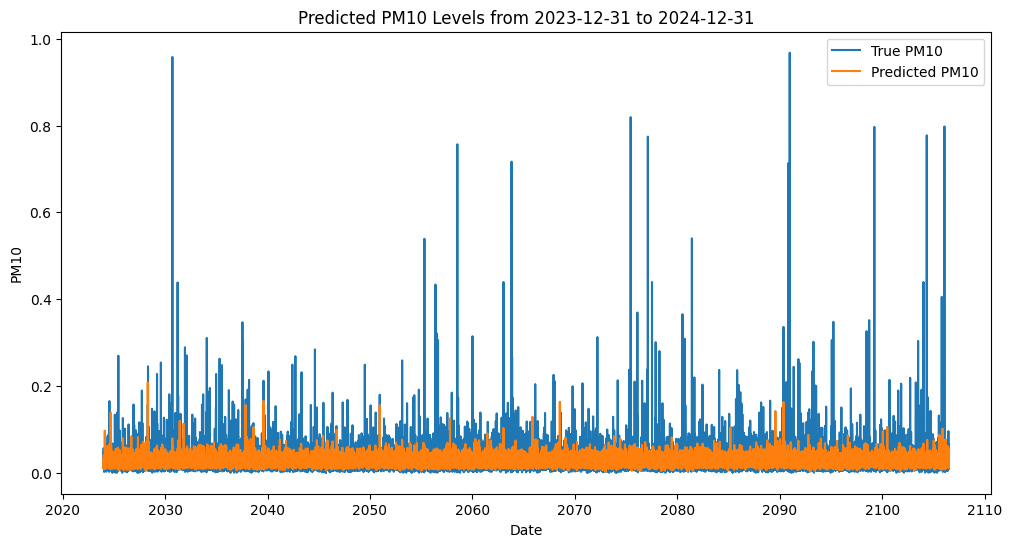

/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes

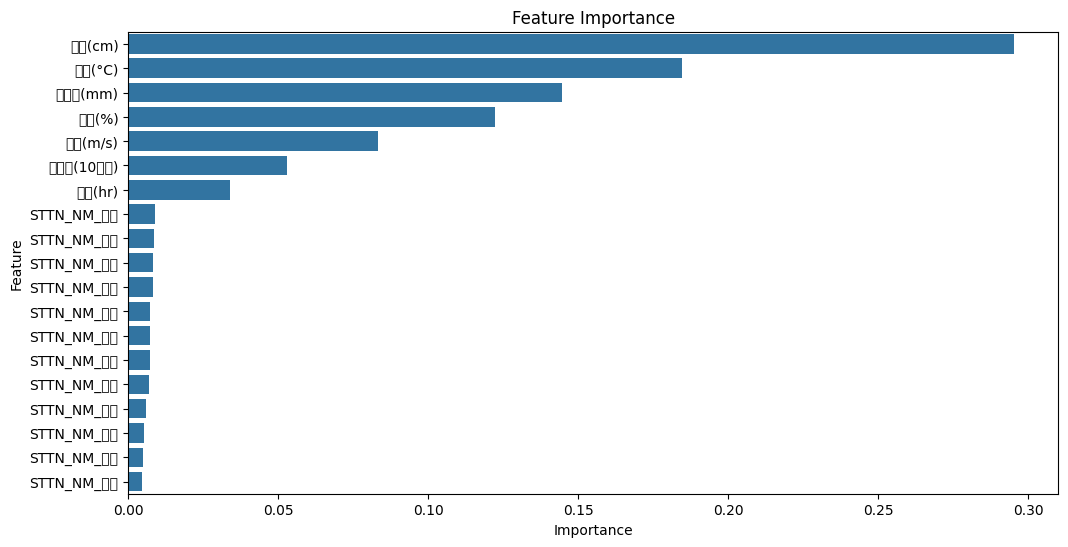

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import seaborn as sns

# CNN 모델 정의
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2))  # PM2.5, PM10 두 개의 출력
    model.compile(optimizer=Adam(), loss='mse')
    return model

# 데이터 로드
df = pd.read_csv('/Users/hayden/Desktop/provincial council internship/df.csv', encoding='utf-8')

# 'MSR_DT'를 datetime 형식으로 변환
df['MSR_DT'] = pd.to_datetime(df['MSR_DT'], format='%Y%m%d%H')

# 'STTN_NM'을 dummy 변수로 변환
df = pd.get_dummies(df, columns=['STTN_NM'])

# 예측할 컬럼 설정
target_col = ['PM10', 'PM25']

# 입력 데이터와 출력 데이터 분리
X = df.drop(['MSR_DT', 'O3', 'CO', 'SO2', 'NO2'] + target_col, axis=1).values
y = df[target_col].values

# 데이터 분할: 90% 훈련, 10% 테스트
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 데이터 차원 변경: CNN을 위해 3차원으로 변환
X_train = X_train[..., np.newaxis]  # (샘플 수, 타임스텝 수, 피처 수, 1)
X_test = X_test[..., np.newaxis]    # (샘플 수, 타임스텝 수, 피처 수, 1)

input_shape = (X_train.shape[1], X_train.shape[2])  # (타임스텝, 피처 수)

# CNN 모델 학습
model = create_cnn_model(input_shape)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)

# 모델 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

test_dates = pd.date_range(start='2023-12-31', periods=len(y_test), freq='D')  # 예제 날짜 생성

# 시각화: 학습 과정에서의 손실
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(test_dates), y_test[:, 1], label='True PM25')
plt.plot(pd.to_datetime(test_dates), y_pred[:, 1], label='Predicted PM25')
plt.title('Predicted PM25 Levels from 2023-12-31 to 2024-12-31')
plt.xlabel('Date')
plt.ylabel('PM25')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(test_dates), y_test[:, 0], label='True PM10')
plt.plot(pd.to_datetime(test_dates), y_pred[:, 0], label='Predicted PM10')
plt.title('Predicted PM10 Levels from 2023-12-31 to 2024-12-31')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.legend()
plt.show()

# Feature importance 평가 (Permutation Importance)
def evaluate_feature_importance(model, X_test, y_test):
    importances = []
    for i in range(X_test.shape[2]):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, :, i])
        permuted_score = model.evaluate(X_test_permuted, y_test, verbose=0)
        importance = permuted_score - model.evaluate(X_test, y_test, verbose=0)
        importances.append(importance)
    return importances

importances = evaluate_feature_importance(model, X_test, y_test)
feature_names = df.drop(['MSR_DT', 'O3', 'CO', 'SO2', 'NO2'] + target_col, axis=1).columns
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importance')
plt.show()


Epoch 1/50
6782/6782 [==============================] - 15s 2ms/step - loss: 3.4682e-05 - val_loss: 8.8206e-07
Epoch 2/50
6782/6782 [==============================] - 15s 2ms/step - loss: 5.1307e-06 - val_loss: 9.8047e-07
Epoch 3/50
6782/6782 [==============================] - 15s 2ms/step - loss: 2.7579e-06 - val_loss: 1.7756e-06
Epoch 4/50
6782/6782 [==============================] - 15s 2ms/step - loss: 1.7440e-06 - val_loss: 1.1168e-06
Epoch 5/50
6782/6782 [==============================] - 17s 2ms/step - loss: 1.1109e-06 - val_loss: 5.6047e-07
Epoch 6/50
6782/6782 [==============================] - 15s 2ms/step - loss: 1.0303e-06 - val_loss: 8.5852e-08
Epoch 7/50
6782/6782 [==============================] - 15s 2ms/step - loss: 9.2766e-07 - val_loss: 2.7863e-07
Epoch 8/50
6782/6782 [==============================] - 15s 2ms/step - loss: 6.7994e-07 - val_loss: 2.8858e-07
Epoch 9/50
6782/6782 [==============================] - 15s 2ms/step - loss: 4.2348e-07 - val_loss: 6.1074e-07
E

Mean Squared Error: 6.892654482726357e-07
Epoch 1/50
6782/6782 [==============================] - 22s 3ms/step - loss: 1.7824e-05 - val_loss: 3.2086e-06
Epoch 2/50
6782/6782 [==============================] - 22s 3ms/step - loss: 1.9859e-06 - val_loss: 3.4034e-07
Epoch 3/50
6782/6782 [==============================] - 24s 4ms/step - loss: 1.2294e-06 - val_loss: 7.5317e-08
Epoch 4/50
6782/6782 [==============================] - 20s 3ms/step - loss: 1.3855e-06 - val_loss: 5.1562e-07
Epoch 5/50
6782/6782 [==============================] - 20s 3ms/step - loss: 3.1654e-07 - val_loss: 7.4957e-09
Epoch 6/50
6782/6782 [==============================] - 24s 4ms/step - loss: 5.4115e-07 - val_loss: 7.0039e-08
Epoch 7/50
6782/6782 [==============================] - 23s 3ms/step - loss: 1.8933e-07 - val_loss: 4.0639e-08
Epoch 8/50
6782/6782 [==============================] - 22s 3ms/step - loss: 2.8631e-07 - val_loss: 2.0057e-09
Epoch 9/50
6782/6782 [==============================] - 22s 3ms/step -

Mean Squared Error: 1.0914277481788304e-07
Epoch 1/50
6782/6782 [==============================] - 43s 6ms/step - loss: 2.4746e-05 - val_loss: 4.6610e-06
Epoch 2/50
6782/6782 [==============================] - 42s 6ms/step - loss: 5.4229e-06 - val_loss: 7.7119e-07
Epoch 3/50
6782/6782 [==============================] - 42s 6ms/step - loss: 2.6830e-06 - val_loss: 9.2099e-07
Epoch 4/50
6782/6782 [==============================] - 40s 6ms/step - loss: 1.9025e-06 - val_loss: 2.7391e-06
Epoch 5/50
6782/6782 [==============================] - 40s 6ms/step - loss: 1.0900e-06 - val_loss: 7.9637e-08
Epoch 6/50
6782/6782 [==============================] - 40s 6ms/step - loss: 9.4879e-07 - val_loss: 1.6914e-07
Epoch 7/50
6782/6782 [==============================] - 39s 6ms/step - loss: 1.0495e-06 - val_loss: 4.5351e-07
Epoch 8/50
6782/6782 [==============================] - 40s 6ms/step - loss: 8.1239e-07 - val_loss: 1.5405e-07
Epoch 9/50
6782/6782 [==============================] - 46s 7ms/step 

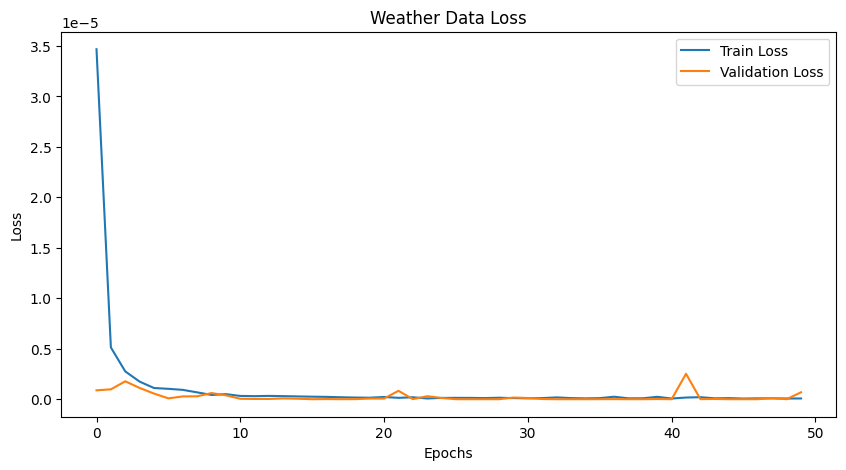

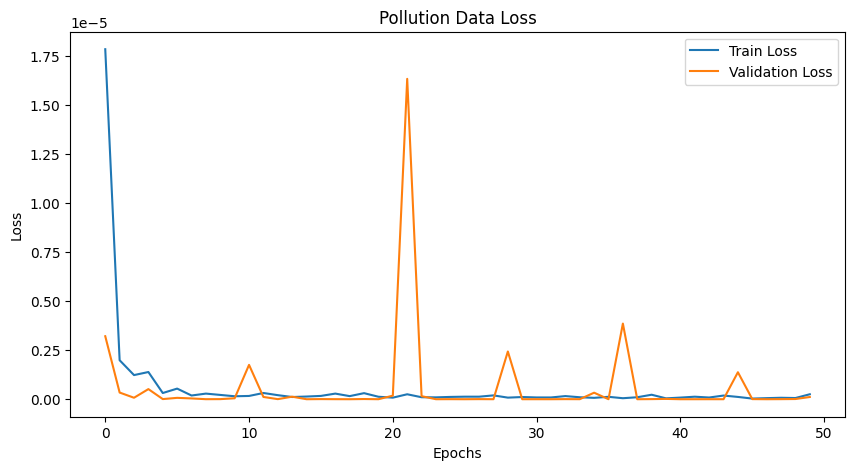

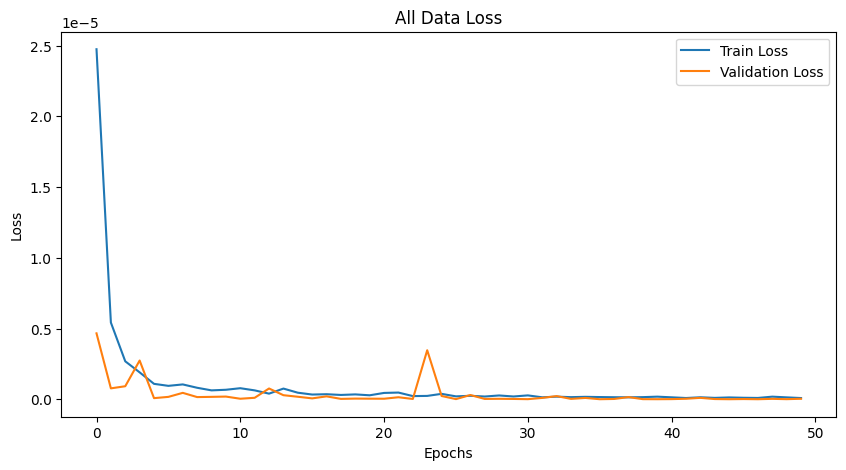

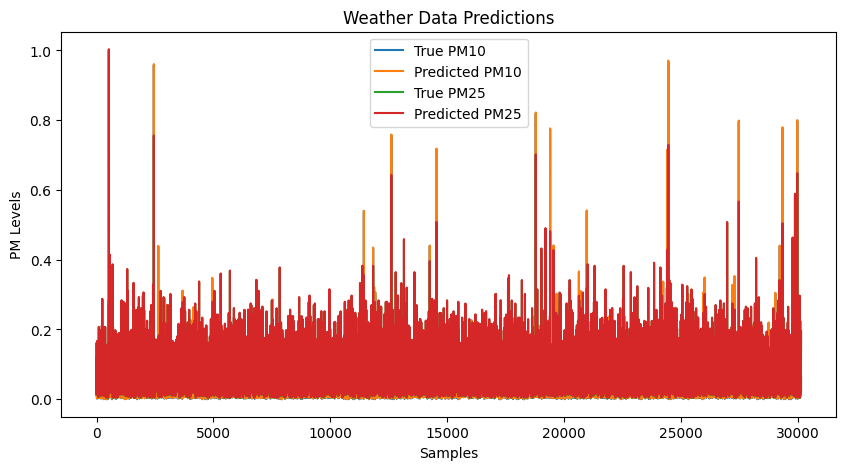

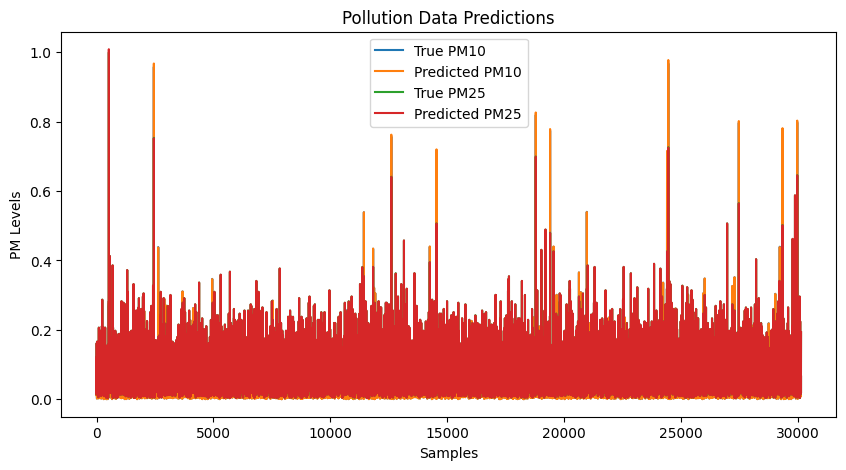

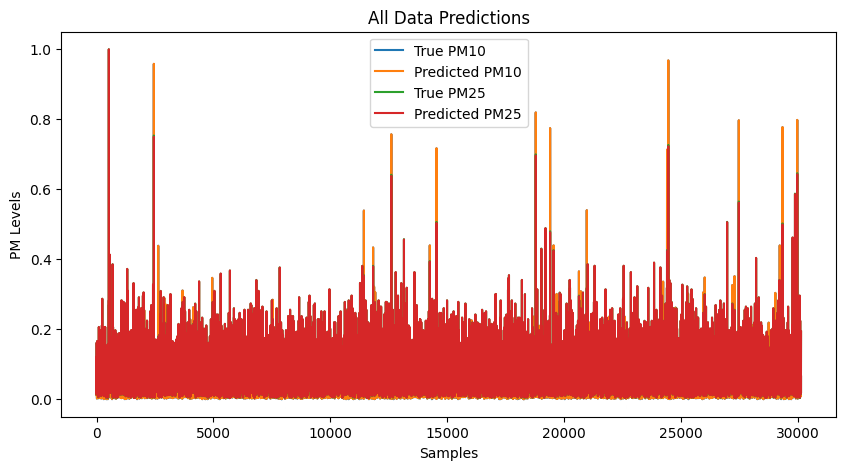

/opt/homebrew/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/homebrew/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/homebrew/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/homebrew/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/homebrew/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/homebrew/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54413 (\N{HANGUL SYLLABLE PUNG}) missing from font(s) DejaVu Sans.
  fig

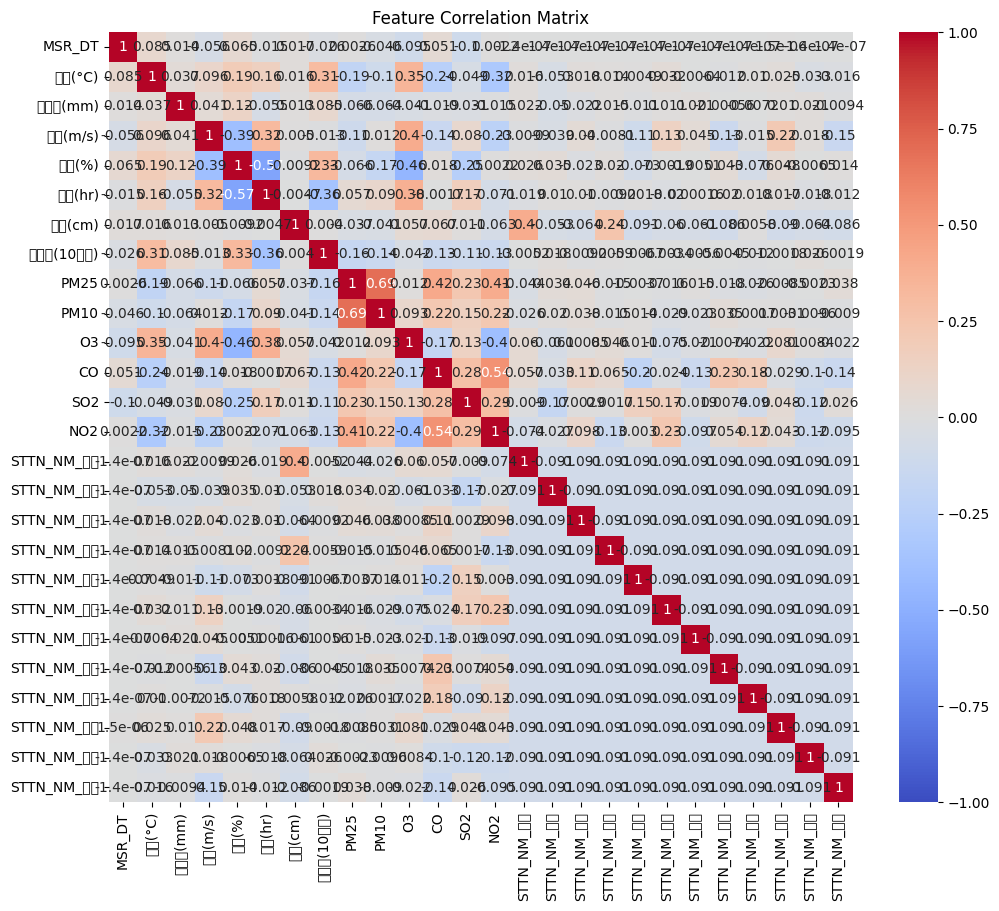

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# CNN 모델 정의
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))  # pool_size를 1로 조정
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=1))  # pool_size를 1로 조정
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2))  # PM2.5, PM10 두 개의 출력
    model.compile(optimizer=Adam(), loss='mse')
    return model

# 데이터 로드
df = pd.read_csv('/Users/hayden/Desktop/provincial council internship/df.csv', encoding='utf-8')

# 'MSR_DT'를 datetime 형식으로 변환
df['MSR_DT'] = pd.to_datetime(df['MSR_DT'], format='%Y%m%d%H')

# 'STTN_NM'을 dummy 변수로 변환
df = pd.get_dummies(df, columns=['STTN_NM'])

# 예측할 컬럼 설정
target_col = ['PM10', 'PM25']

# 데이터셋 분리 함수
def prepare_data(input_cols):
    X = df[input_cols].values
    y = df[target_col].values
    X = X.astype(np.float32)
    y = y.astype(np.float32)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    return X_train, X_test, y_train, y_test

# 기상 데이터셋
weather_cols = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '적설(cm)', '전운량(10분위)'] + target_col
X_train_weather, X_test_weather, y_train, y_test = prepare_data(weather_cols)

# 대기오염물질 데이터셋
pollution_cols = ['O3', 'CO', 'SO2', 'NO2'] + target_col
X_train_pollution, X_test_pollution, y_train, y_test = prepare_data(pollution_cols)

# 전체 데이터셋
all_cols = weather_cols + pollution_cols
X_train_all, X_test_all, y_train, y_test = prepare_data(all_cols)

# 모델 학습 및 평가 함수
def train_and_evaluate_model(X_train, X_test, y_train, y_test, input_shape):
    model = create_cnn_model(input_shape)
    history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    return history, mse, y_pred

# 기상 데이터셋 학습 및 평가
history_weather, mse_weather, y_pred_weather = train_and_evaluate_model(X_train_weather, X_test_weather, y_train, y_test, (X_train_weather.shape[1], X_train_weather.shape[2]))

# 대기오염물질 데이터셋 학습 및 평가
history_pollution, mse_pollution, y_pred_pollution = train_and_evaluate_model(X_train_pollution, X_test_pollution, y_train, y_test, (X_train_pollution.shape[1], X_train_pollution.shape[2]))

# 전체 데이터셋 학습 및 평가
history_all, mse_all, y_pred_all = train_and_evaluate_model(X_train_all, X_test_all, y_train, y_test, (X_train_all.shape[1], X_train_all.shape[2]))

# 성능 비교
print(f'MSE (Weather only): {mse_weather}')
print(f'MSE (Pollution only): {mse_pollution}')
print(f'MSE (All data): {mse_all}')

# 학습 과정에서의 손실 시각화
def plot_loss(history, title):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history_weather, 'Weather Data Loss')
plot_loss(history_pollution, 'Pollution Data Loss')
plot_loss(history_all, 'All Data Loss')

# 예측 결과 시각화
def plot_predictions(y_test, y_pred, title):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test[:, 0], label='True PM10')
    plt.plot(y_pred[:, 0], label='Predicted PM10')
    plt.plot(y_test[:, 1], label='True PM25')
    plt.plot(y_pred[:, 1], label='Predicted PM25')
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('PM Levels')
    plt.legend()
    plt.show()

plot_predictions(y_test, y_pred_weather, 'Weather Data Predictions')
plot_predictions(y_test, y_pred_pollution, 'Pollution Data Predictions')
plot_predictions(y_test, y_pred_all, 'All Data Predictions')

# 피쳐 간 상관관계 시각화
corr = df.corr()
plt.figure(figsize=(12, 10))
plt.title('Feature Correlation Matrix')
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()
